## Analysis of the FVA results for the Octanoate Base Case 
(limited oxygen and nitrogen uptake, c-source is octanoate and pha is produced)

### setup

In [2]:
import extFunc as ext
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np
from importlib import import_module
import pandas as pd 
import cobra
import seaborn as sns
import optlang
import copy 
import random

In [3]:
%%capture
#Load Models if not already in RAM

#nameList = ['iJN1462_GLC_UR10_9.xml' , 'iJN1462_GLC_UR6_3.xml', 'iJN1462_GLN_UR5_1.xml', 'iJN1462_GLC_UR7_3.xml' , 'iJN1462_OCT_UR3_4.xml']
#nameList = ['iJN1462_GLC_UR6_3.xml' , 'iJN1462_OCT_UR3_4.xml']
nameList = ['iJN1462_OCT_UR3_4.xml']


if 'modelDict' not in locals():
    modelDict = ext.ImportFunction(nameList)



if 'glc_oct_comp'  not in locals():
    glc_oct_comp = ext.ModelComparison(modelDict=modelDict)


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


## FVA analysis


In [4]:
%%capture
#Base case as in Nogales Paper
model           = modelDict['iJN1462_OCT_UR3_4']

model.reactions.EX_octa_e.upper_bound  = -3.4
model.reactions.EX_octa_e.lower_bound  = -3.4

model.reactions.EX_o2_e.upper_bound  = 0
model.reactions.EX_o2_e.lower_bound  = -13.5

model.reactions.EX_nh4_e.upper_bound  = 0
model.reactions.EX_nh4_e.lower_bound  = -3.1

model_bounded   = copy.deepcopy(model)

fv                  = cobra.flux_analysis.flux_variability_analysis(model , pfba_factor=1.1 )
fv["cumulative"]    = abs(fv.maximum) + abs(fv.minimum)


## FVA analysis, Plotting FVA, filterig extreme FVA, influnce of the filtered?


### filtering reactions fva>200 
Assumption through high default boundaries overal variability artificially strethed ?
Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

length of the filtered array = 171


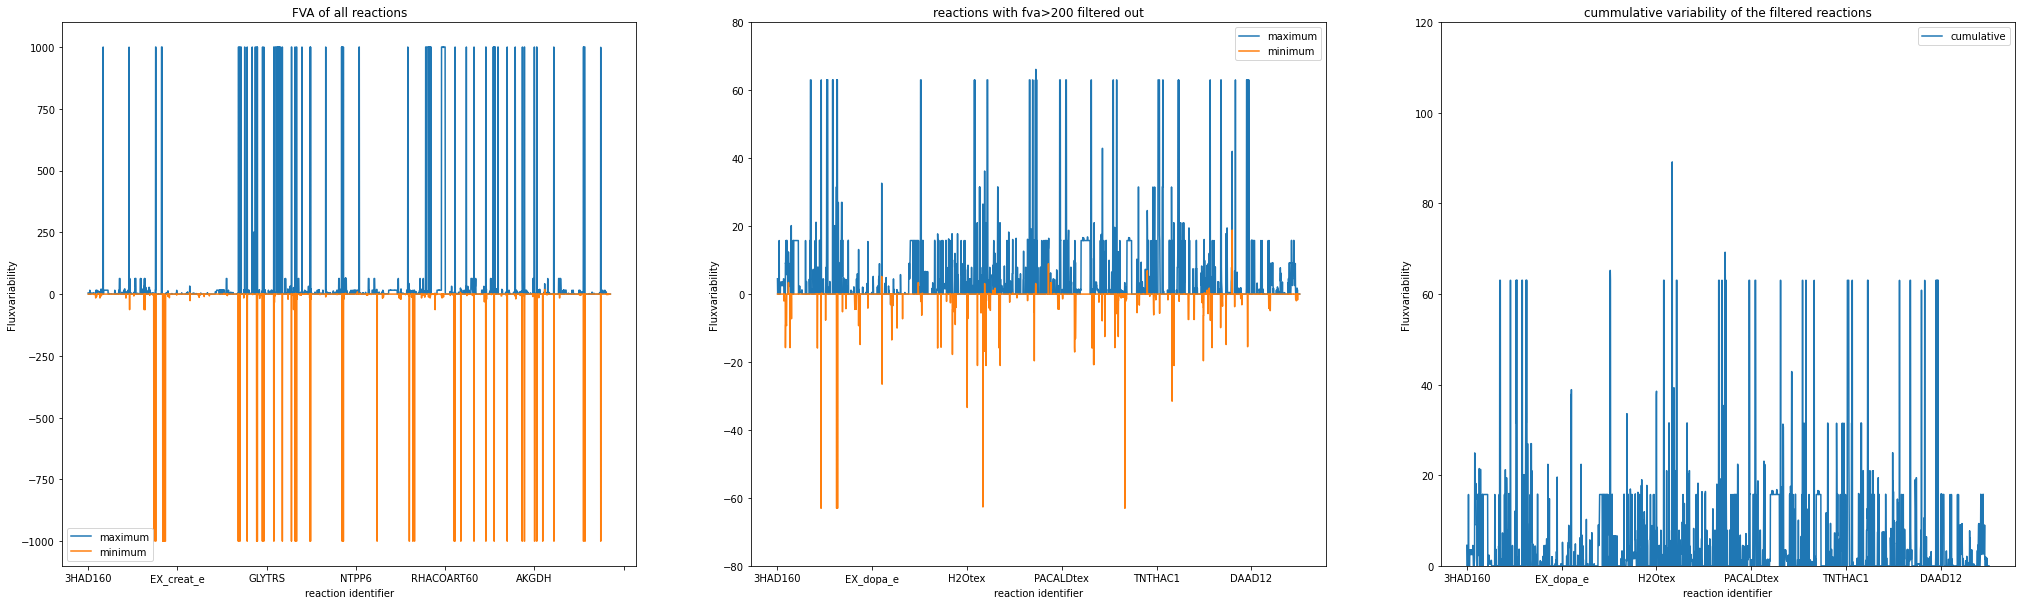

In [4]:
filterV = 200

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(35,10))
fv.plot( y=["maximum", "minimum"],ax=axes[0],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="FVA of all reactions")
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["maximum", "minimum"],
        ax=axes[1],ylim=[-80,80],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="reactions with fva>200 filtered out")
fv[(abs(fv.maximum)<filterV) & (abs(fv.minimum)<filterV)].plot( y=["cumulative"],
        ax=axes[2],ylim=[0,120],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="cummulative variability of the filtered reactions")

## save list of filtered for later

list_of_filtered = fv[(abs(fv.maximum)>filterV) | (abs(fv.minimum)>filterV)]
print("length of the filtered array = "+str(len(list_of_filtered)))
#print(list_of_filtered.index)


In [5]:

bounded_model = copy.deepcopy(model)

for reaction in bounded_model.reactions:
    if abs(reaction.lower_bound)>filterV:
        reaction.lower_bound= filterV*np.sign(reaction.lower_bound)
    if abs(reaction.upper_bound)>filterV:
        reaction.upper_bound =  filterV *np.sign(reaction.upper_bound)
        
fv_new_model  = cobra.flux_analysis.flux_variability_analysis(bounded_model)
fv_new_model["cumulative"]    = abs(fv_new_model.maximum) + abs(fv_new_model.minimum)

<AxesSubplot:title={'center':'cummulative fva values'}, xlabel='reaction identifier', ylabel='Fluxvariability'>

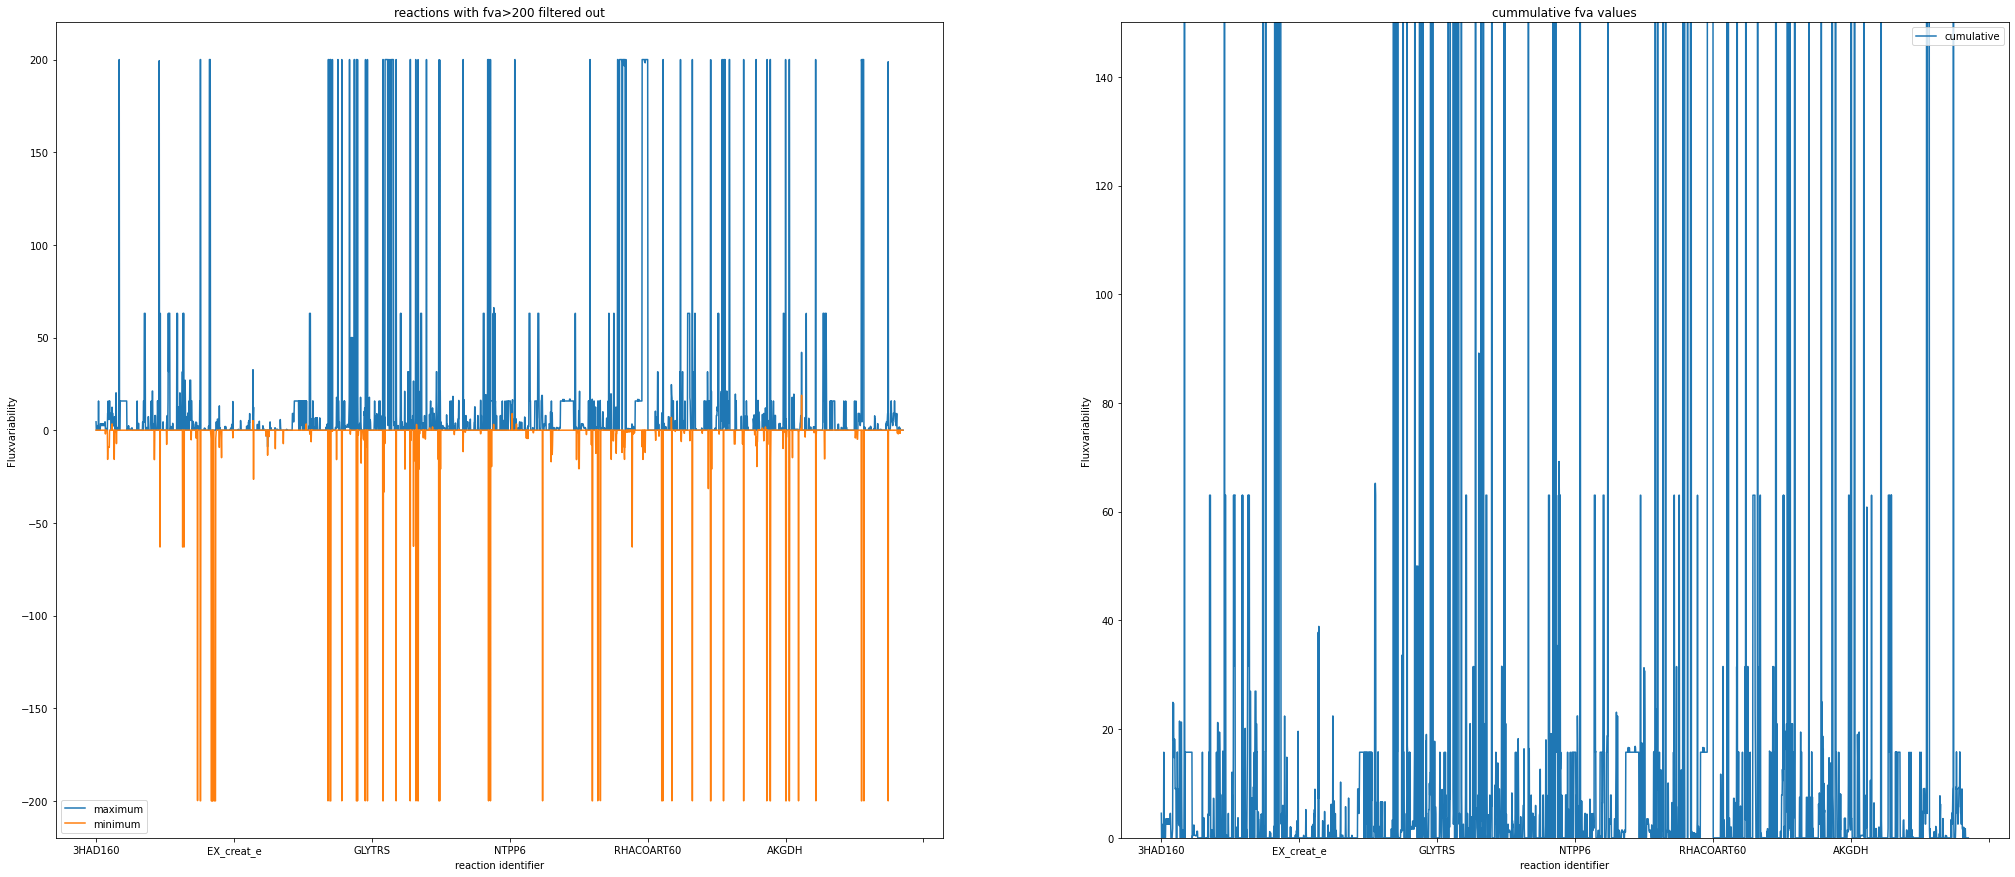

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fv_new_model.plot( 
        y=["maximum", "minimum"],
        ax=axes[0],figsize=(35,15),
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="reactions with fva>200 filtered out"
        )
fv_new_model.plot( 
        y=["cumulative"],
        ax=axes[1],ylim=[0,150],
        ylabel="Fluxvariability",
        xlabel="reaction identifier",
        title="cummulative fva values"
        )


#### Assumption through high default boundaries overal variability artificially strethed ?
#### Test, Measure the overall cumulative variability for the bounded and unbound optimized cases.
#### If a difference is visible after removig the artificially stretched reactions, this would mean that theire was an influence

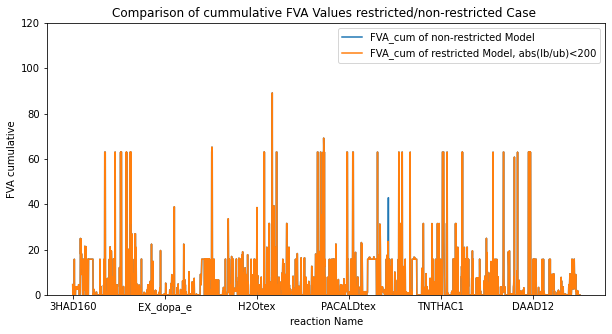

In [7]:
filter = list_of_filtered.index

ax1 =   fv[~fv.index.isin(filter)].plot( y=["cumulative"],ylim=[0,120])
fv_new_model[~fv_new_model.index.isin(filter)].plot( y=["cumulative"],ax=ax1,
title = "Comparison of cummulative FVA Values restricted/non-restricted Case ",
xlabel = "reaction Name",
ylabel = "FVA cumulative"
)

ax1.legend(["FVA_cum of non-restricted Model", "FVA_cum of restricted Model, abs(lb/ub)<200"])



Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries 2
seems as if a signifant account might be numerical, because of small differences 


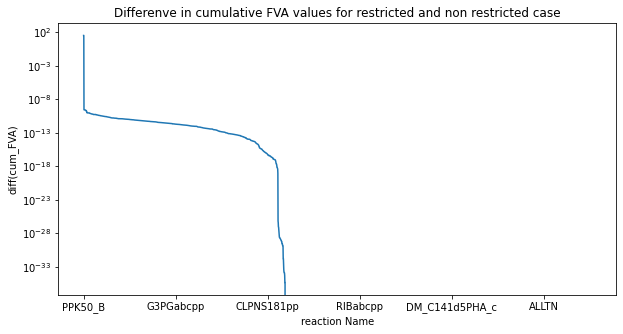

In [8]:
diff=fv[~fv.index.isin(filter)]["cumulative"] - fv_new_model[~fv_new_model.index.isin(filter)]["cumulative"]
diff.sort_values(ascending=False).plot(logy=True,
title = "Differenve in cumulative FVA values for restricted and non restricted case",
xlabel = "reaction Name",
ylabel = "diff(cum_FVA)"
)
nonzero_diff = diff[diff > 1e-5]

print("Number of reactions,for which the result of the FVA changed through reducing the biggest boundaries " + str(len(nonzero_diff)))
print("seems as if a signifant account might be numerical, because of small differences ")

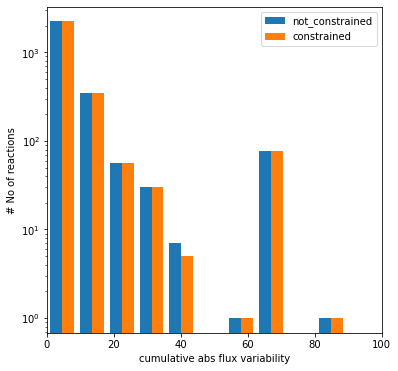

In [9]:
#bin_array = np.logspace(1e-4,1e+4,9)
#fv[~fv.index.isin(filter)].hist(column=["cumulative"],log=True, bins=50,figsize=(5,5))
#fv_new_model[~fv_new_model.index.isin(filter)]hist(column=["cumulative"] , log=True,bins=50,ax=axA)

comp = pd.DataFrame()
comp['notConstrained']=fv[~fv.index.isin(filter)]["cumulative"]
comp['constrained']=fv_new_model[~fv_new_model.index.isin(filter)]["cumulative"]

fig=plt.figure(figsize=(6,6))
 
plt.xlabel('cumulative abs flux variability')
plt.xlim([0,100])

plt.ylabel('# No of reactions')
plt.hist(comp,log=True,label=["not_constrained","constrained"])

plt.legend()

### comparing flux distribution for the filtered and not filtered case

In [10]:
modelDict2 = {
    "baseCaseOctanoat" : model ,
    "boundariesLimited to +/- 200" : bounded_model 
    }

comparisonObjectBoundaedModels = ext.ModelComparison(modelDict=modelDict2)
comparisonObjectBoundaedModels.multiModellSummary(fvaDIr=.99,sortKrit='C-Flux')

Uptake                          \
                                metabolite      reaction      flux   
baseCaseOctanoat             0     octa[e]     EX_octa_e  3.400000   
                             1  pqqA_kt[c]  SK_pqqA_kt_c  0.000065   
                             2      nh4[e]      EX_nh4_e  3.100000   
                             3     PHAg[c]     SK_PHAg_c  1.117172   
                             4      zn2[e]      EX_zn2_e  0.000820   
boundariesLimited to +/- 200 0     octa[e]     EX_octa_e  3.400000   
                             1  pqqA_kt[c]  SK_pqqA_kt_c  0.000065   
                             2      nh4[e]      EX_nh4_e  3.100000   
                             3     PHAg[c]     SK_PHAg_c  1.117172   
                             4      zn2[e]      EX_zn2_e  0.000820   

                                                                                \
                                                                         range   
baseCaseOctanoat             0                                      (3.4, 3.4)   
                             1   (6.49463753195905e-05, 6.494637531956774e-05)   
                             2                        (3.100000000000208, 3.1)   
                             3                        (0.0, 2.133283116797014)   
                             4  (0.0008204212523555446, 0.0008204212523598527)   
boundariesLimited to +/- 200 0                                      (3.4, 3.4)   
                             1  (6.494637531958671e-05, 6.494637531957468e-05)   
                             2                       (3.0999999999999974, 3.1)   
                             3                        (0.0, 2.133283116797376)   
                             4  (0.0008204212523554965, 0.0008204212523550348)   

                                                      Secretion  \
                               C-Number     C-Flux   metabolite   
baseCaseOctanoat             0        8  99.996657   C80aPHA[c]   
                             1       14   0.003343       co2[e]   
                             2        0   0.000000  R_3hocta[e]   
                             3        0   0.000000        ac[e]   
                             4        0   0.000000     5drib[c]   
boundariesLimited to +/- 200 0        8  99.996657   C80aPHA[c]   
                             1       14   0.003343       co2[e]   
                             2        0   0.000000  R_3hocta[e]   
                             3        0   0.000000        ac[e]   
                             4        0   0.000000     5drib[c]   

                                                         \
                                     reaction      flux   
baseCaseOctanoat             0   DM_C80aPHA_c -1.117172   
                             1       EX_co2_e -3.171260   
                             2  EX_R_3hocta_e -0.377543   
                             3        EX_ac_e -0.171264   
                             4     DM_5drib_c -0.000195   
boundariesLimited to +/- 200 0   DM_C80aPHA_c -1.117172   
                             1       EX_co2_e -3.171260   
                             2  EX_R_3hocta_e -0.377543   
                             3        EX_ac_e -0.171264   
                             4     DM_5drib_c -0.000195   

                                                                                   \
                                                                            range   
baseCaseOctanoat             0                           (-1.54479122250867, 0.0)   
                             1           (-15.471574935978161, 4.138146416900379)   
                             2                         (-1.5342104607169431, 0.0)   
                             3                          (-7.747578797457919, 0.0)   
                             4   (-0.0004546246291878382, -0.0001948391259587715)   
boundariesLimited to +/- 200 0                         (-1.5447912225085427, 0.0)   
                

## Analysis of the reactions which are filtered

In [11]:
fl = bounded_model.optimize().fluxes
fl[abs(fl)>5]

ACONTa         7.199553
ACONTb         7.199553
CS             7.199553
CYTBO3_4pp    26.860260
EX_co2_e       6.485095
EX_h2o_e      15.199860
EX_o2_e      -13.500000
FUM            7.152739
H2Otex       -15.199860
H2Otpp       -15.209771
ICL            5.212970
MDH2           7.910961
NTP1           7.229256
O2tex         13.500000
O2tpp         13.498931
SUCD4          7.873648
SUCDi          6.935829
ATPS4rpp      29.028999
CO2tex        -6.485095
CO2tpp        -6.485095
Name: fluxes, dtype: float64

<AxesSubplot:title={'center':'Flux results of the filtered reactions'}, ylabel='Frequency'>

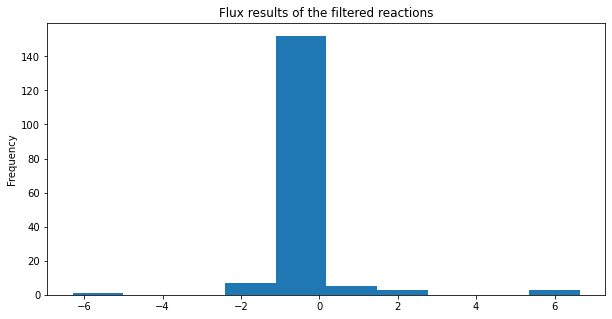

In [12]:
fl = model.optimize().fluxes
fl[list_of_filtered.index].plot.hist(
    title="Flux results of the filtered reactions",
    xlabel="Fluxvalues ")

### Are theire exchange reactions being filtered out 

In [13]:
list_of_filtered.index = list_of_filtered.index.astype('str')
list_of_filtered[list_of_filtered.index.str.contains('EX')]

,minimum,maximum,cumulative


## Analysis of FVA of the reaction which are on the Carbon conversion Path

/Users/ivanlizat/opt/anaconda3/envs/hiwi/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


ACOAD3f         4
EX_octa_e       1
FACOAL80t2pp    3
OCTAtex         2
PHAP2C80        6
RECOAH3         5
DM_C80aPHA_c    7
Name: ind_nr, dtype: int64

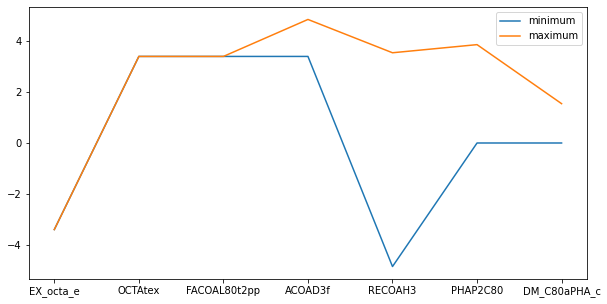

In [10]:

octanoate_path_reaction_ids =   ["OCTAtex", "FACOAL80t2pp", "ACOAD3f","RECOAH3", "ACSPHAC80","PHADPC80","DM_C80aPHA_c"]
octanoate_path_reaction_ids =   ["EX_octa_e", "OCTAtex", "FACOAL80t2pp","ACOAD3f", "RECOAH3","PHAP2C80",'DM_C80aPHA_c']

ind_nr                      =   [4, 1, 3,2,6,5 ,7]
fv_main_carbonpath = fv[fv.index.isin(octanoate_path_reaction_ids)]

fv_main_carbonpath.loc[:,"ind_nr"] = ind_nr
fv_main_carbonpath.sort_values("ind_nr").plot(y=['minimum','maximum'])

fv_main_carbonpath.loc[:,"ind_nr"]

<AxesSubplot:>

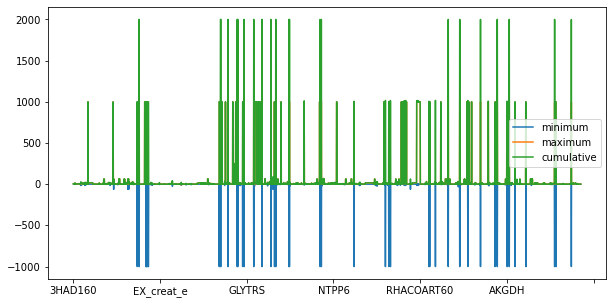

In [15]:
fv.plot()